
Random Forest Results:
                    precision    recall  f1-score   support

              Ally      0.436     0.531     0.479        32
            Herald      0.519     0.560     0.538        25
              Hero      0.333     0.167     0.222         6
            Mentor      0.000     0.000     0.000         2
            Shadow      0.000     0.000     0.000         5
      Shapeshifter      0.000     0.000     0.000         3
Threshold Guardian      0.333     0.143     0.200         7
         Trickster      0.286     0.222     0.250         9

          accuracy                          0.393        89
         macro avg      0.238     0.203     0.211        89
      weighted avg      0.380     0.393     0.379        89

Macro F1-score: 0.211

Logistic Regression Results:
                    precision    recall  f1-score   support

              Ally      0.706     0.375     0.490        32
            Herald      0.594     0.760     0.667        25
              Hero  

/Users/jazzydelossantos/Desktop/CalPoly/fall-qtr-25/csc466_finalproj/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


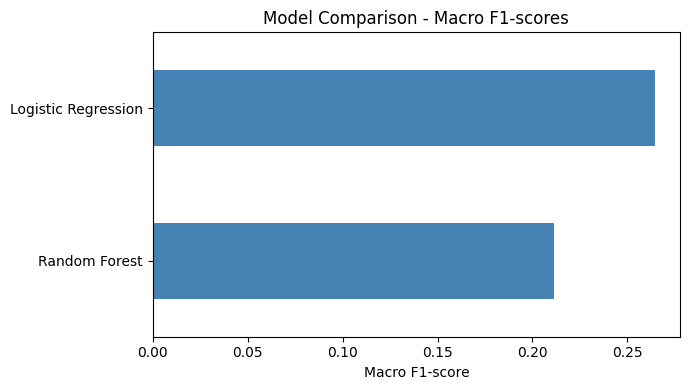


Summary:
                  Model  Macro F1-score
1  Logistic Regression        0.264483
0        Random Forest        0.211195


In [1]:
# ===============================
# Multi-Model Comparison for Archetype Classifier
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --- Load and prepare data ---
character_df = pd.read_csv('../csv/all_plays_char_stats.csv')
archetype_df = pd.read_csv('../csv/all_char_archetypes.csv')
df = pd.merge(character_df, archetype_df, on=['character', 'play'], how='inner')

feature_cols = [
    "speech_share_pct", "line_share_pct", "avg_speeches_per_scene", "avg_lines_per_speech",
    "verbosity", "talkativeness", "dominance", "focus", "breadth"
]
X = df[feature_cols].fillna(0)
y = df['campbell_archetype']

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# --- Define models ---
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, class_weight='balanced', random_state=42
    ),
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced')
    )
}

# --- Train, evaluate, and store results ---
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    results[name] = f1
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Macro F1-score: {f1:.3f}")

# --- Plot comparison ---
plt.figure(figsize=(7, 4))
(pd.Series(results)
 .sort_values()
 .plot(kind='barh', color='steelblue'))
plt.title("Model Comparison - Macro F1-scores")
plt.xlabel("Macro F1-score")
plt.tight_layout()
plt.show()

# Optional: print summary table
summary = pd.DataFrame(list(results.items()), columns=['Model', 'Macro F1-score']).sort_values('Macro F1-score', ascending=False)
print("\nSummary:\n", summary)



Random Forest Results:
Macro F1-score: 0.222
Macro ROC AUC: 0.636

Logistic Regression Results:
Macro F1-score: 0.223
Macro ROC AUC: 0.683


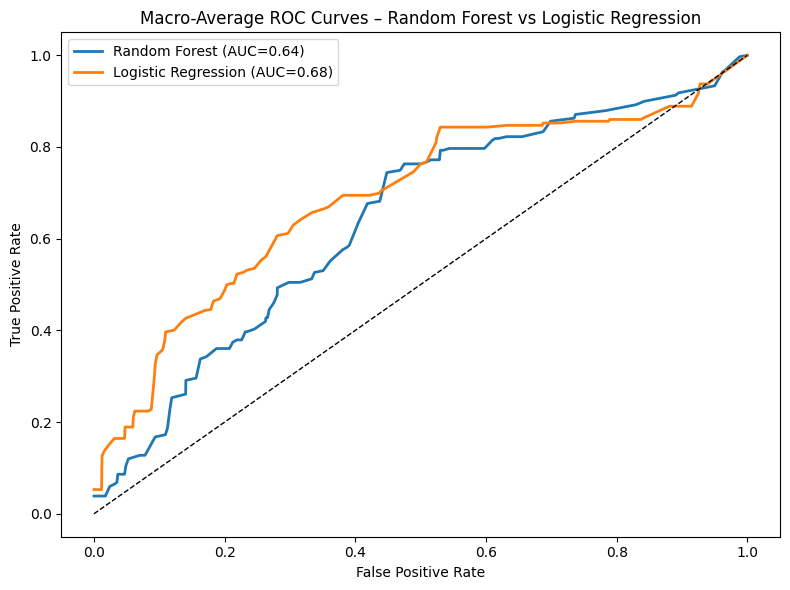

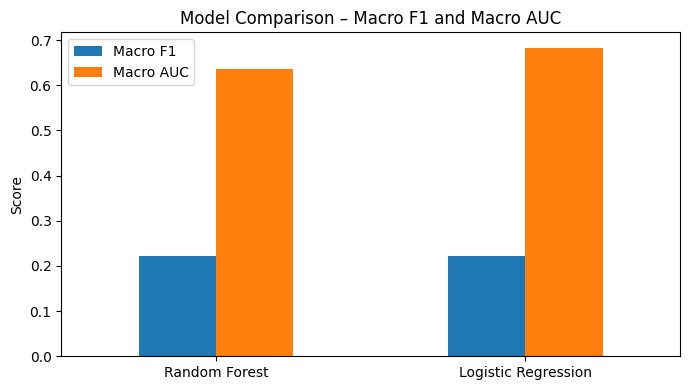


Summary:
                      Macro F1  Macro AUC
Random Forest           0.222      0.636
Logistic Regression     0.223      0.683


In [4]:
# ===============================
# Multi-Model Comparison with ROC and AUC
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# --- Load and prepare data ---
character_df = pd.read_csv('../csv/all_plays_char_stats.csv')
archetype_df = pd.read_csv('../csv/all_char_archetypes.csv')
df = pd.merge(character_df, archetype_df, on=['character', 'play'], how='inner')

feature_cols = [
    "speech_share_pct", "line_share_pct", "avg_speeches_per_scene", "avg_lines_per_speech",
    "verbosity", "talkativeness", "dominance", "focus", "breadth"
]
X = df[feature_cols].fillna(0)
y = df['campbell_archetype']

# Encode labels numerically for ROC
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_bin = label_binarize(y_enc, classes=range(len(le.classes_)))
n_classes = y_bin.shape[1]

# --- Split data ---
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, stratify=y_bin, test_size=0.3, random_state=42
)

# --- Define models (as OvR for multi-class ROC) ---
models = {
    "Random Forest": OneVsRestClassifier(
        RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, max_depth=5)
    ),
    "Logistic Regression": OneVsRestClassifier(
            LogisticRegression(max_iter=1000, class_weight='balanced')
        )
    
}

# --- Train, evaluate, and store results ---
results = {}
roc_curves = {}

for name, model in models.items():
    model.fit(X_train, y_train_bin)
    y_score = model.predict_proba(X_test)
    y_pred = np.argmax(y_score, axis=1)
    y_true = np.argmax(y_test_bin, axis=1)
    
    # F1 + AUC
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
    results[name] = {'Macro F1': f1, 'Macro AUC': auc_macro}
    
    print(f"\n{name} Results:")
    print(f"Macro F1-score: {f1:.3f}")
    print(f"Macro ROC AUC: {auc_macro:.3f}")

    # Compute macro-average ROC curve
    fpr_dict, tpr_dict = {}, {}
    for i in range(n_classes):
        if y_test_bin[:, i].sum() < 2:  # skip rare classes
            continue
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        fpr_dict[i], tpr_dict[i] = fpr, tpr
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in fpr_dict]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in fpr_dict:
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= len(fpr_dict)
    roc_curves[name] = (all_fpr, mean_tpr)

# --- Plot ROC curves for both models ---
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={results[name]['Macro AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curves – Random Forest vs Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

# --- Bar chart comparison (F1 + AUC) ---
summary = pd.DataFrame(results).T
summary.plot(kind='bar', figsize=(7,4))
plt.title("Model Comparison – Macro F1 and Macro AUC")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nSummary:\n", summary.round(3))
